In [4]:
import numpy as np, xarray as xr, matplotlib.pylab as plt, pandas as pd, seaborn as sns
import pickle, random, re, io, regionmask, dask, timeit, os, shutil, datetime
from scipy.signal import welch; from eofs.xarray import Eof; import matplotlib as mpl

from statsmodels.tsa.api import VAR; from contextlib import redirect_stdout
from distributed import Client; from scipy import stats
import cartopy.crs as ccrs, cartopy.feature as cfeature
import matplotlib.gridspec as gridspec; import cartopy.feature as cfeature
from matplotlib.colors import Normalize; import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from InVERT_functions import (calc_weights, concat_with_monthids, calc_EOFs, areaweighted_mean, 
autocorr, unstack_time, stack_time, createRandomSortedList, compare_T_pdfs, calc_psd_stats, 
plot_GMST_psd_spread, calc_emean_autocorrs, calc_ensemble_std_autocorrs, calc_efold_time, 
calc_eft_stats, compare_autocorrs_emean, plot_GMST_comparisons, save_region_means,
plot_regional_psd_spread, plot_regional_T_pdfs, plot_regional_emean_autocorrs, 
plot_regional_comparison, find_var_name, compare_MSE_to_emean_PSD, welch_psd, get_ensemble_variance, 
calc_emean_gridcell_MSE, plot_regional_variance_stats, plot_regional_eft_stats,
gridcell_map_plot, plot_gridcell_diff, plot_regional_diff_map, calc_gridcell_psd, plot_MSE_by_region,
calc_efold_time_dataset, plot_var_coeffs, convert_lon, emulate_pcs, plot_local_monthly_T_stds,
calc_gridcell_monthly_autocorrs)

In [5]:
# Figure formatting
mpl.rcParams['font.family'] = 'sans-serif' 
tickfontsize = 14; axislabelfontsize=16
titlefontsize=18; legendfontsize=14
color1 = 'goldenrod'; color2='teal'

## Figure S9 
Global mean surface temperature anomaly (a) PDF, (b) power spectral density, and (c) lag autocorrelations for LENS2 Historical (green) and LENS2 SSP370 (purple) simulations.





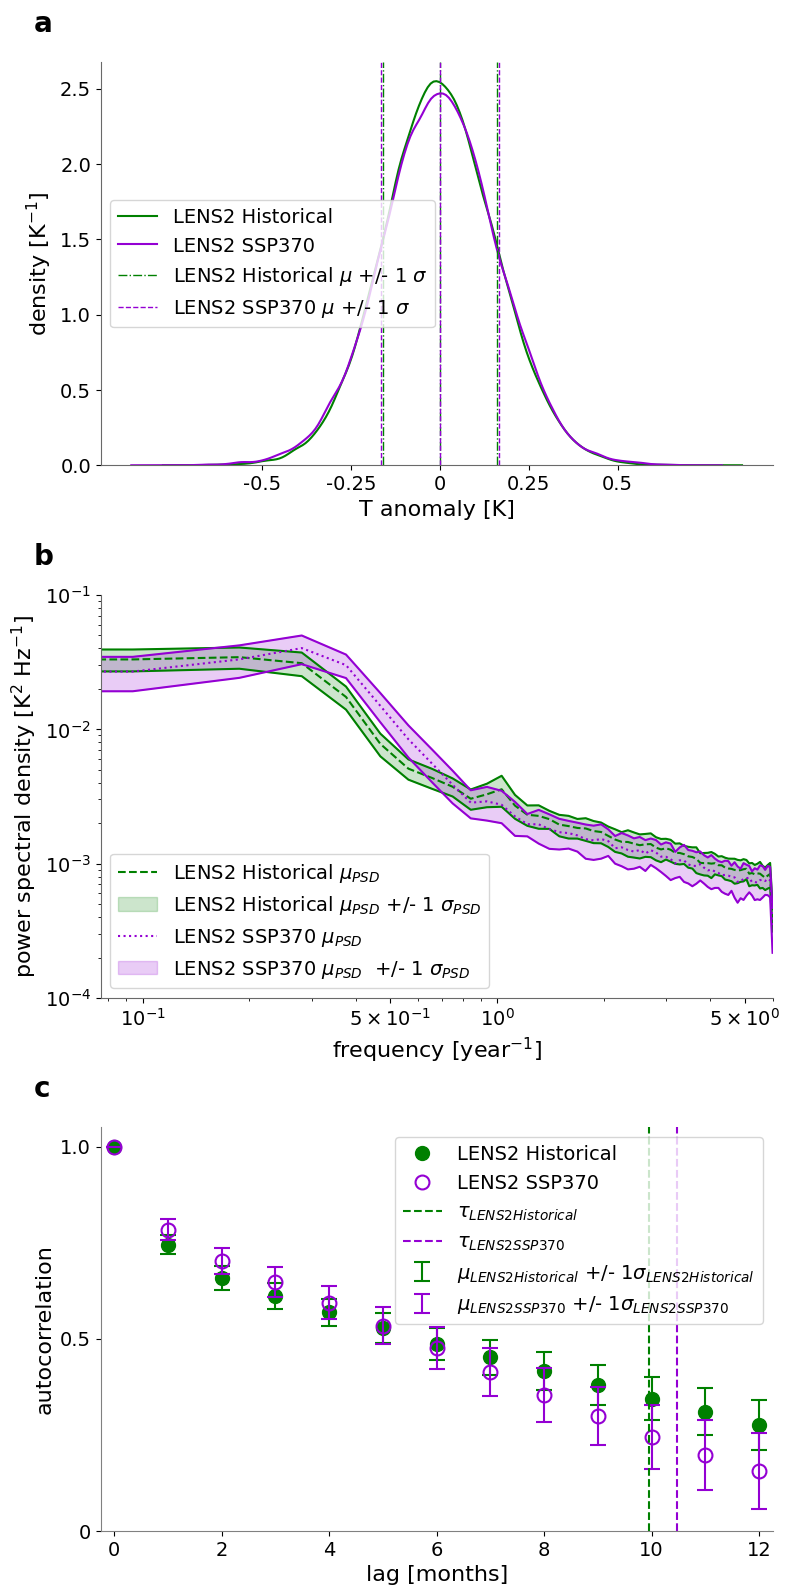

In [6]:
hpath = '/home/msaenger/LENS2_Historical/TREFHT/'
spath = '/home/msaenger/LENS2_SSP370/TREFHT/'

anoms_stacked_HIST = xr.open_dataset(hpath + 'LENS2_TREFHT_anomalies_regridded_concatted.nc')
anoms_HIST = xr.open_dataset(hpath + 'LENS2_TREFHT_anomalies_regridded.nc')
anoms_stacked_SSP = xr.open_dataset(spath + 'LENS2_TREFHT_anomalies_regridded_concatted.nc')
anoms_SSP = xr.open_dataset(spath + 'LENS2_TREFHT_anomalies_regridded.nc')

savepath = '/home/msaenger/InVERT/output/SSP370/'

titlefontsize=20
plot_GMST_comparisons(anoms_HIST, anoms_SSP, 
                      anoms_stacked_HIST, anoms_stacked_SSP,
                      name1='LENS2 Historical', name2='LENS2 SSP370',
                      color1='green', color2='darkviolet', path=savepath,
                      save_name = 'Figure_S9_Hist_vs_SSP370_GMST')

## Figures S1, S2, and S6: diagnostics for InVERT trained on LENS2 SSP370 simulations

#### Train InVERT on SSP370 data

In [7]:
scenario = 'SSP370'

lpath = '/home/msaenger/LENS2_' + scenario + '/TREFHT/'

In [8]:
n_samples = 25   # number of InVERT ensemble members to generate
n_steps = 12 * 85   # number of time steps (months) to generate per InVERT ensemble member (length of SSP370)
optimal_lag = 12 # VAR model lag (months)

nmodes = 100     # number of EOF modes to include
M = 120          # Number of initial time steps (months) to truncate for spin-up (aka 'burn-in' period)

In [1]:
LENS_esize = 50  # Size of LENS ensemble (number of members)

In [10]:
# # #### DATA PREPROCESSING ####

# path = '/home/msaenger/LENS2_' + scenario + \
#        '/TREFHT/combined_by_ensemble_member/regridded/'

# ## combine 50 regridded ensemble member files into one dataset with 'ensemble' dimension
# ds = xr.open_mfdataset(path + '*.nc', concat_dim='ensemble', 
#                          combine='nested', parallel=True)

# ## assign ensemble coordinate
# ds = ds.assign_coords(ensemble=np.arange(len(ds['ensemble'])))

# ## Calculate ensemble mean and add to dataset as a variable
# ds['emean'] = ds.TREFHT.mean('ensemble')


# ## subtract ensemble mean to get anomalies 
# anoms = ds['TREFHT'] - ds['emean']

# anoms = anoms.to_dataset(name='anoms')
# anoms['gmean'] = areaweighted_mean(anoms.anoms)

In [11]:
# anoms.to_netcdf(lpath + 'LENS2_TREFHT_anomalies_regridded.nc')

In [15]:
anoms = xr.open_dataset(lpath + 'LENS2_TREFHT_anomalies_regridded.nc')

anoms_concatted = concat_with_monthids(anoms.anoms)

anoms_concatted['gmean'] = areaweighted_mean(anoms_concatted.anoms)

# ## Save month IDs from original T anomaly time series
month_da = xr.DataArray(anoms_concatted.month.values,
                        coords={'time': anoms_concatted.time.values, 
                                'month': ('time', anoms_concatted.month.values)},
                        dims=['time'])

month_da.to_netcdf(savepath + 'month_da.nc')
# anoms_concatted['month'] = month_da

# ## Save anomalies stacked in time
# anoms_concatted.to_netcdf(lpath + 'LENS2_TREFHT_anomalies_regridded_concatted.nc')

In [16]:
## Randomly select a subset of ensemble members train on

n_training_members = 25 # Number of training ensemble members to use

training_members = (createRandomSortedList(n_training_members))
print('training members:', training_members)
training_anoms = anoms.sel(ensemble = [ens for ens in training_members])
training_anoms.to_netcdf(savepath + 'LENS2_Tanoms_' + str(n_training_members) + '_training_members.nc')

training members: [1, 3, 5, 6, 9, 10, 11, 12, 15, 16, 17, 18, 19, 21, 25, 26, 27, 28, 32, 40, 42, 43, 46, 47, 49]


In [17]:
## Concatenate training ensemble members over time dimension and save

training_anoms_concatted = concat_with_monthids(training_anoms.anoms)

## Save month IDs from original T anomaly time series
month_da = xr.DataArray(training_anoms_concatted.month.values,
                        coords={'time': training_anoms_concatted.time.values, 
                                'month': ('time', training_anoms_concatted.month.values)},
                        dims=['time'])

training_anoms_concatted['month'] = month_da
training_anoms_concatted['gmean'] = areaweighted_mean(training_anoms_concatted.anoms)

training_anoms_concatted.to_netcdf(savepath + \
                        'LENS2_concatted_Tanoms_25_training_members.nc')
month_da.to_netcdf(savepath + 'month_da.nc')

In [18]:
## Save non-training ensemble members for diagnostics (testing)

testing_ensembles = [i for i in np.arange(0,50) if i not in training_members]
testing_anoms = anoms.sel(ensemble = random.sample(testing_ensembles, 25))
print('testing members:', testing_anoms.ensemble.values)                     
testing_anoms.to_netcdf(savepath + 'LENS2_Tanoms_25_testing_members.nc')

testing members: [13 34 23  4 35 14 29 45 31  7 38  2 37 30 48  0 44 36  8 39 20 41 33 24
 22]


In [19]:
## Concatenate non-training ensemble members over time dimension and save 

testing_anoms_concatted = concat_with_monthids(testing_anoms.anoms)
## Save month IDs from original T anomaly time series
month_da = xr.DataArray(testing_anoms_concatted.month.values,
                        coords={'time': testing_anoms_concatted.time.values, 
                                'month': ('time', testing_anoms_concatted.month.values)},
                        dims=['time'])
testing_anoms_concatted['month'] = month_da
testing_anoms_concatted['gmean'] = areaweighted_mean(testing_anoms_concatted.anoms)
testing_anoms_concatted.to_netcdf(savepath + \
            'LENS2_concatted_Tanoms_25_testing_members.nc')

In [20]:
### Calculate month-specific EOFs from training ensemble members

scenario_name = 'SSP370'

for month in range(1,13):
    month_EOFs = calc_EOFs(training_anoms_concatted.groupby('month')[month].anoms, path=savepath,
                      filename = 'LENS2_'+scenario_name+'_training_monthly_Tanom_EOFs_month='+str(month))
    print('month ' + str(month) + ' EOFs saved')

calculating EOFs
done
month 1 EOFs saved
calculating EOFs
done
month 2 EOFs saved
calculating EOFs
done
month 3 EOFs saved
calculating EOFs
done
month 4 EOFs saved
calculating EOFs
done
month 5 EOFs saved
calculating EOFs
done
month 6 EOFs saved
calculating EOFs
done
month 7 EOFs saved
calculating EOFs
done
month 8 EOFs saved
calculating EOFs
done
month 9 EOFs saved
calculating EOFs
done
month 10 EOFs saved
calculating EOFs
done
month 11 EOFs saved
calculating EOFs
done
month 12 EOFs saved


In [21]:
# ## Load EOF solvers by month from training ensemble members

solvers_bymonth = {}
for month in range(1,13):
    solvers_bymonth[month] = calc_EOFs(0, path=savepath, filename='LENS2_'+scenario_name + \
                                       '_training_monthly_Tanom_EOFs_month='+str(month))

Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver
Loading EOF solver


In [22]:
## Extract and save PCs, EOFs, and variance fractions from the EOF solver object
eofs_dict = {}
for month in range(1, 13):
    eofs_dict[month] = {}
    eofs_dict[month]['eofs'] = solvers_bymonth[month].eofs().sel(mode=slice(0, nmodes-1))
    eofs_dict[month]['pcs'] = solvers_bymonth[month].pcs().sel(mode=slice(0, nmodes-1))
    eofs_dict[month]['varfracs'] = solvers_bymonth[month].varianceFraction().sel(mode=slice(0, nmodes-1))
    
## Extract cos(lat) weights for later use
weights = solvers_bymonth[1].getWeights()
weights = xr.DataArray(weights, coords=[eofs_dict[1]['eofs']['lat'], 
                                        eofs_dict[1]['eofs']['lon']], 
                       dims=['lat', 'lon'])

### Compile DataArrays of PCs from the EOF solvers for each month
pcs_unstacked = {}
for month in range(1, 13):
    pcs_unstacked[month] = unstack_time(eofs_dict[month]['pcs'].drop('month'), 
                                        esize = n_training_members) 
training_pcs_bymonth_unstacked = xr.Dataset(pcs_unstacked)
training_pcs_bymonth = stack_time(training_pcs_bymonth_unstacked)

In [23]:
# ## Extract each month's PC data array and adjust the 'time' values so as to put them 
# ## back together in time order (e.g. month 1 year 1, month 2 year 1, ... month 12 year 1, 
# ## month 1 year 2, month 2 year 2, ... etc)
month_pc_da_list = []
for month in range(1, 13):
    training_pcs_da_month = training_pcs_bymonth[month].drop('ensemble')
    training_pcs_da_month['time'] = training_pcs_da_month.time * 12 + month - 1
    training_pcs_da_month = training_pcs_da_month.to_dataset(name='pcs')
    month_pc_da_list.append(training_pcs_da_month)

month_da = xr.open_dataarray(savepath + 'month_da.nc')

training_pcs = xr.merge(month_pc_da_list).sortby('time')
training_pcs['month'] = month_da.sel(time=slice(0,len(training_pcs['time'])))
training_pcs = training_pcs.assign_coords({'month': training_pcs.month})

training_pcs.to_netcdf(savepath + 'training_pcs.nc')

In [24]:
### Train 12 monthly VAR models 
monthly_var_models = {}

for target_month in range(1, 13): 
    input_features = []; output_targets = []

    for i in range(optimal_lag, len(training_pcs.time)):
        if training_pcs.month.values[i] == target_month:
            
            features = training_pcs.pcs.values[i - optimal_lag : i, :].flatten()
            input_features.append(features)
            targets = training_pcs.pcs.values[i, :]
            output_targets.append(targets)
    input_features = np.array(input_features); output_targets = np.array(output_targets)

    if len(input_features) > 0:
        X = np.hstack([np.ones((input_features.shape[0],1)), input_features])
        y = output_targets

        coefficients, residuals_info, rank, s = np.linalg.lstsq(X, y, rcond=None)
        predicted_targets = X @ coefficients
        residuals = y - predicted_targets
        intercept = coefficients[0, :]
        lagged_coeffs = coefficients[1:, :]

        monthly_var_models[target_month] = {
            'intercept': intercept,
            'lagged_coeffs': lagged_coeffs.reshape((optimal_lag, nmodes, nmodes)), 
            'residuals': residuals} 

In [25]:
## Create a list to store DataArrays for each month
monthly_coeffs_da_list = []
lags_coord = np.arange(optimal_lag, 0, -1) # Lags from 12 down to 1 (e.g. 'months ago')
input_modes_coord = np.arange(nmodes); output_modes_coord = np.arange(nmodes)

for month, components in monthly_var_models.items():
    lagged_coeffs = components['lagged_coeffs']

    coeffs_da = xr.DataArray(lagged_coeffs,
                             coords={'lag': lags_coord,
                                     'input_mode': input_modes_coord,
                                     'output_mode': output_modes_coord},
                             dims=['lag', 'input_mode', 'output_mode'])
    coeffs_da = coeffs_da.expand_dims(month=[month])
    monthly_coeffs_da_list.append(coeffs_da)
    
lagged_coeffs_dataset = xr.concat(monthly_coeffs_da_list, dim='month')
lagged_coeffs_dataset = lagged_coeffs_dataset.to_dataset(name='lagged_coefficients')
lagged_coeffs_dataset.to_netcdf(savepath + 'lagged_coeff_dataset.nc')

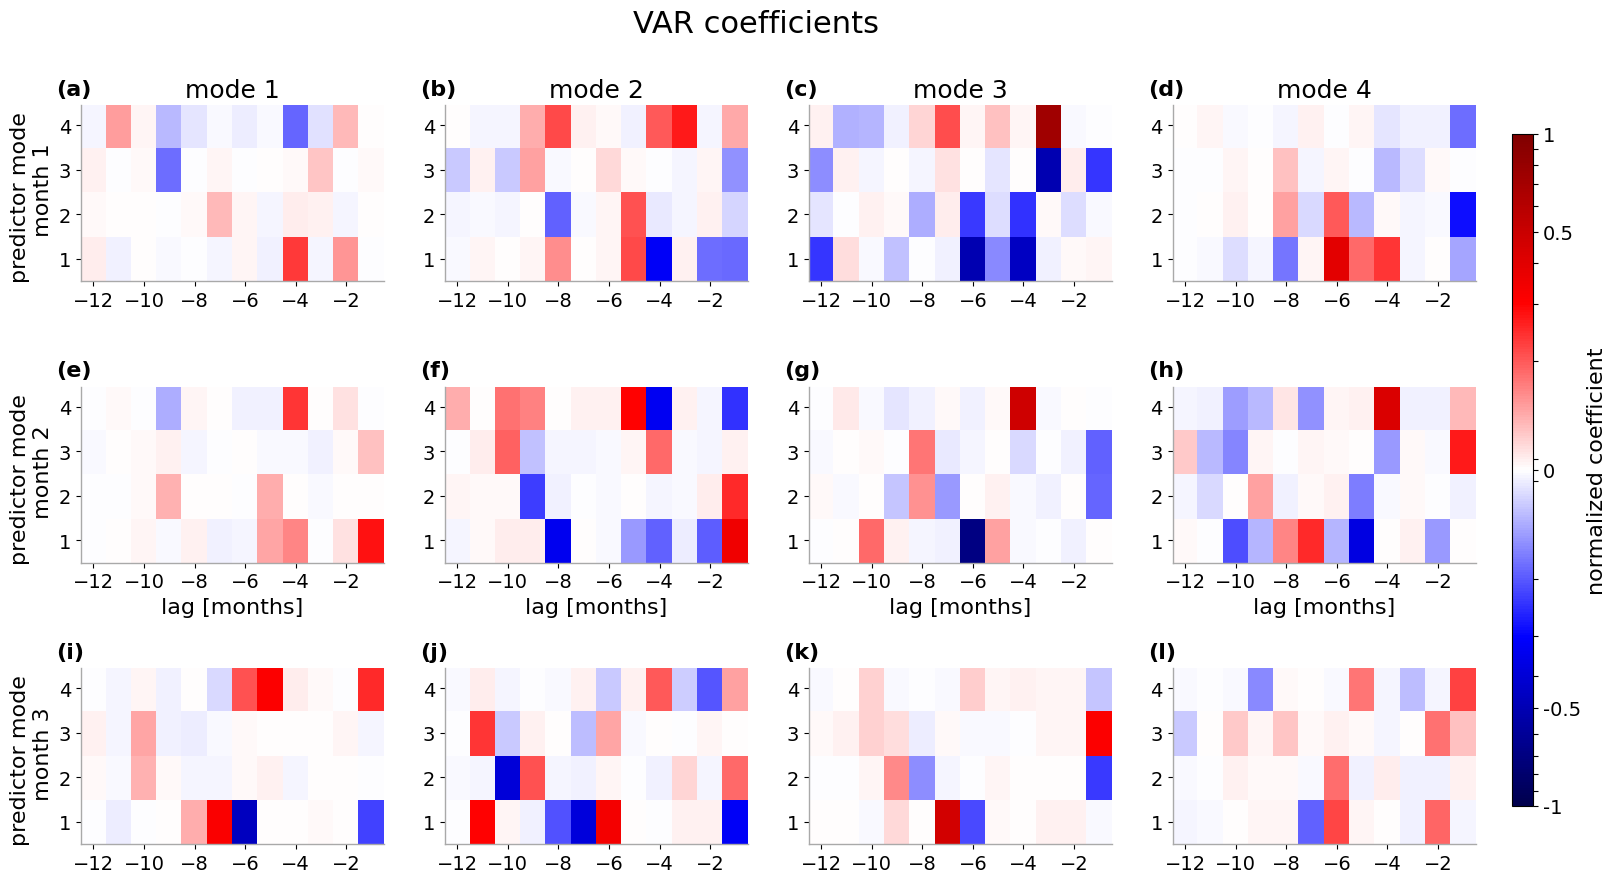

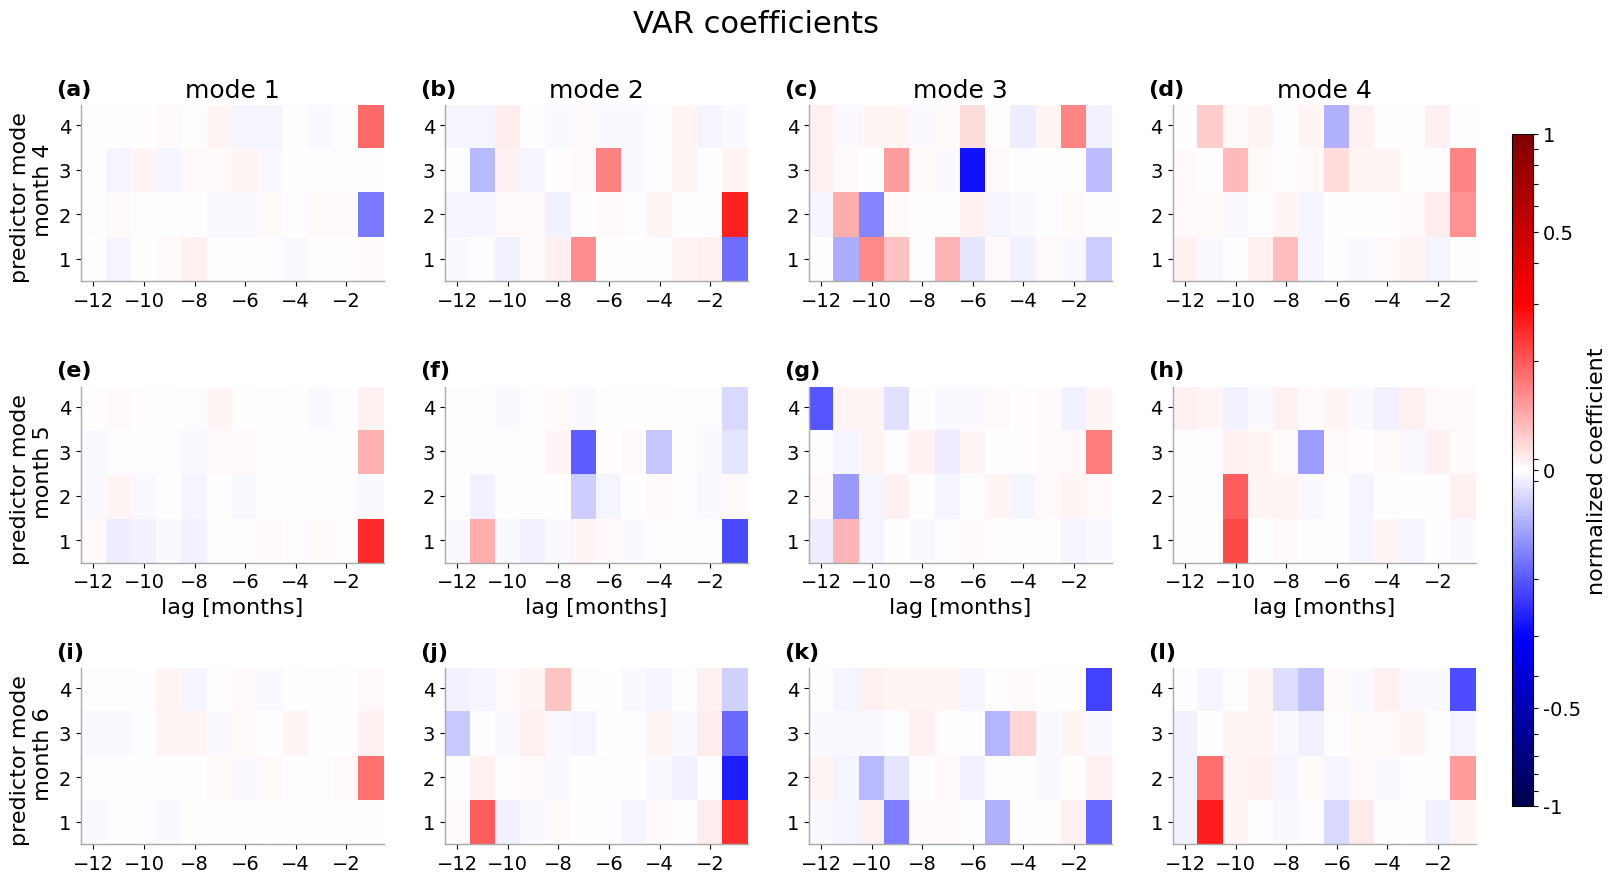

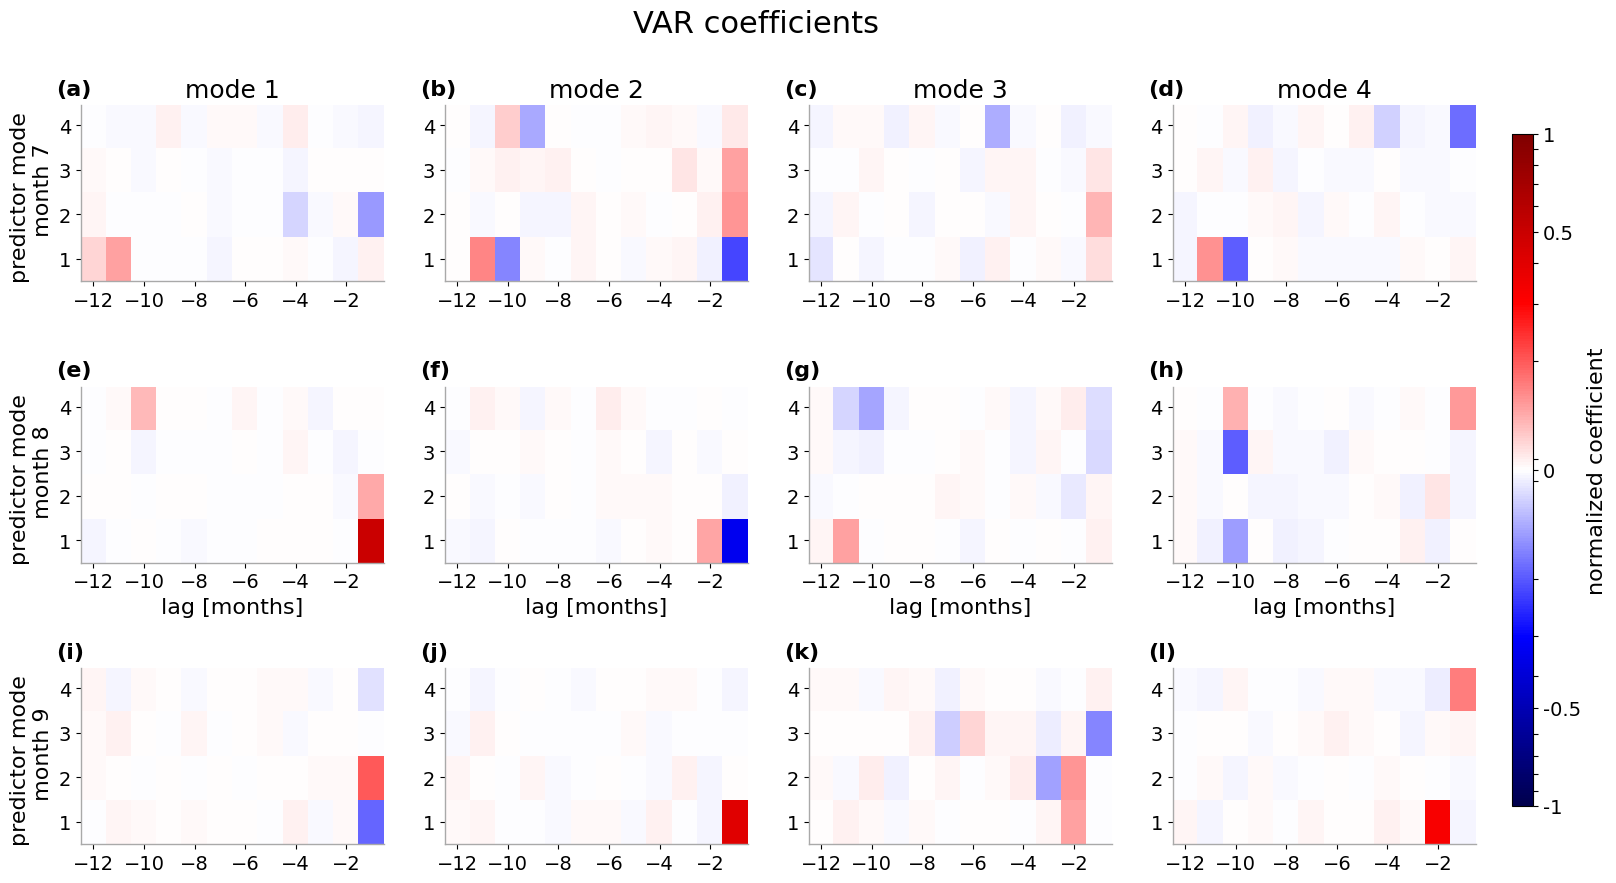

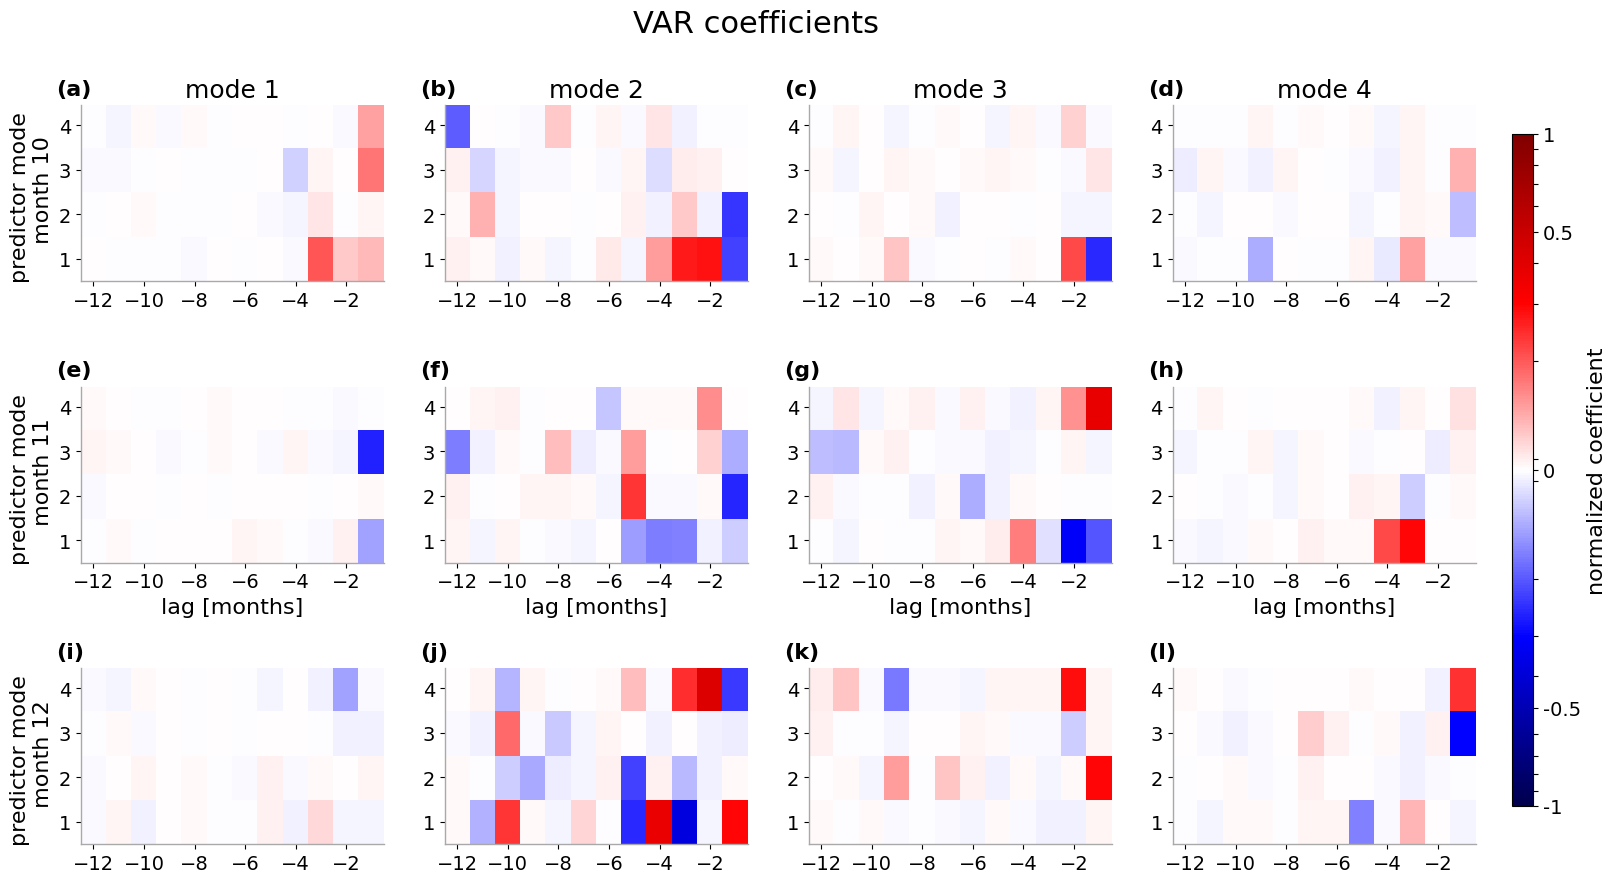

In [26]:
## Plot VAR coefficients
plot_var_coeffs(lagged_coeffs_dataset, months_per_row=[1,2,3], savepath=savepath)
plot_var_coeffs(lagged_coeffs_dataset, months_per_row=[4,5,6], savepath=savepath)
plot_var_coeffs(lagged_coeffs_dataset, months_per_row=[7,8,9], savepath=savepath)
plot_var_coeffs(lagged_coeffs_dataset, months_per_row=[10,11,12], savepath=savepath)

In [27]:
## Emulate PCs and save

InVERT_pcs = emulate_pcs(training_pcs, monthly_var_models, n_training_members,
                         optimal_lag, n_samples, n_steps, nmodes, M, savepath)

In [28]:
## Load emulated PCs
InVERT_pcs = xr.open_dataset(savepath + 'InVERT_PCs.nc')

In [29]:
## Separate PCs back into separate months, multiply by EOFs independently, and re-merge sorted by time
## Compute PCs * EOFs for each mode and divide by weights for every month. Save in dict.

print('Multiplying PCs * EOFs and dividing by weights')
products_by_month = {}
for month in range(1, 13):
    print(month)
    products_by_month[month] = InVERT_pcs.groupby('month')[month] * eofs_dict[month]['eofs'] / weights
    
## Sum T anomalies over modes then merge
print('Summing over modes')
products_by_month_summed = {}
for month in range(1, 13):
    print(month)
    products_by_month_summed[month] =  products_by_month[month].pcs.sum(dim='mode')
    
## Re-stack ensemble members over time dim and save in new dict
print('Stacking ensemble members over time')
Tanoms_bymonth = {}
for month in range(1, 13):
    print(month)
    Tanoms_bymonth[month] = (stack_time(products_by_month_summed[month]))
    
## Extract each month's T anomaly data array and adjust the 'time' values so as to put them 
## back together in time order 
print('Updating time indices')
Tanom_da_list = []
for month in range(1, 13):
    Tanoms_month = Tanoms_bymonth[month]
    Tanoms_month['time'] = Tanoms_month.time * 12 + month - 1
    Tanoms_month = Tanoms_month.to_dataset(name='T')
    Tanom_da_list.append(Tanoms_month)
    
## Concatenate over time dimension and then sort by time 
print('Merging and sorting by time')

InVERT_stacked = xr.concat(Tanom_da_list, dim='time').sortby('time')
InVERT_stacked['gmean'] = areaweighted_mean(InVERT_stacked.T)
InVERT_stacked.to_netcdf(savepath + 'InVERT_stacked.nc')

## Separate back into ensemble members
InVERT_T = unstack_time(InVERT_stacked, esize=n_samples)

print('Saving final SSP370 InVERT dataset')
InVERT_T.to_netcdf(savepath + 'InVERT_'+str(nmodes)+'modes_lag='+str(optimal_lag)+'.nc')
print('saved')

Multiplying PCs * EOFs and dividing by weights
1
2
3
4
5
6
7
8
9
10
11
12
Summing over modes
1
2
3
4
5
6
7
8
9
10
11
12
Stacking ensemble members over time
1
2
3
4
5
6
7
8
9
10
11
12
Updating time indices
Merging and sorting by time
Saving final SSP370 InVERT dataset
saved


#### Diagnostics

In [16]:
print('SSP370 Diagnostics')

InVERT_T = xr.open_dataset(savepath + 'InVERT_'+str(nmodes)+'modes_lag='+str(optimal_lag)+'.nc')
## Concatenate emulated ensemble members in time
InVERT_stacked = xr.open_dataset(savepath + 'InVERT_stacked.nc')

SSP370 Diagnostics


In [17]:
## Load non-training LENS2 T anomaly data
## stacked in time
Tanoms_lens = xr.open_dataset(savepath + 'LENS2_concatted_Tanoms_25_testing_members.nc')
## separate back into ensemble members
T_unstacked = unstack_time(Tanoms_lens, esize=LENS_esize//2)

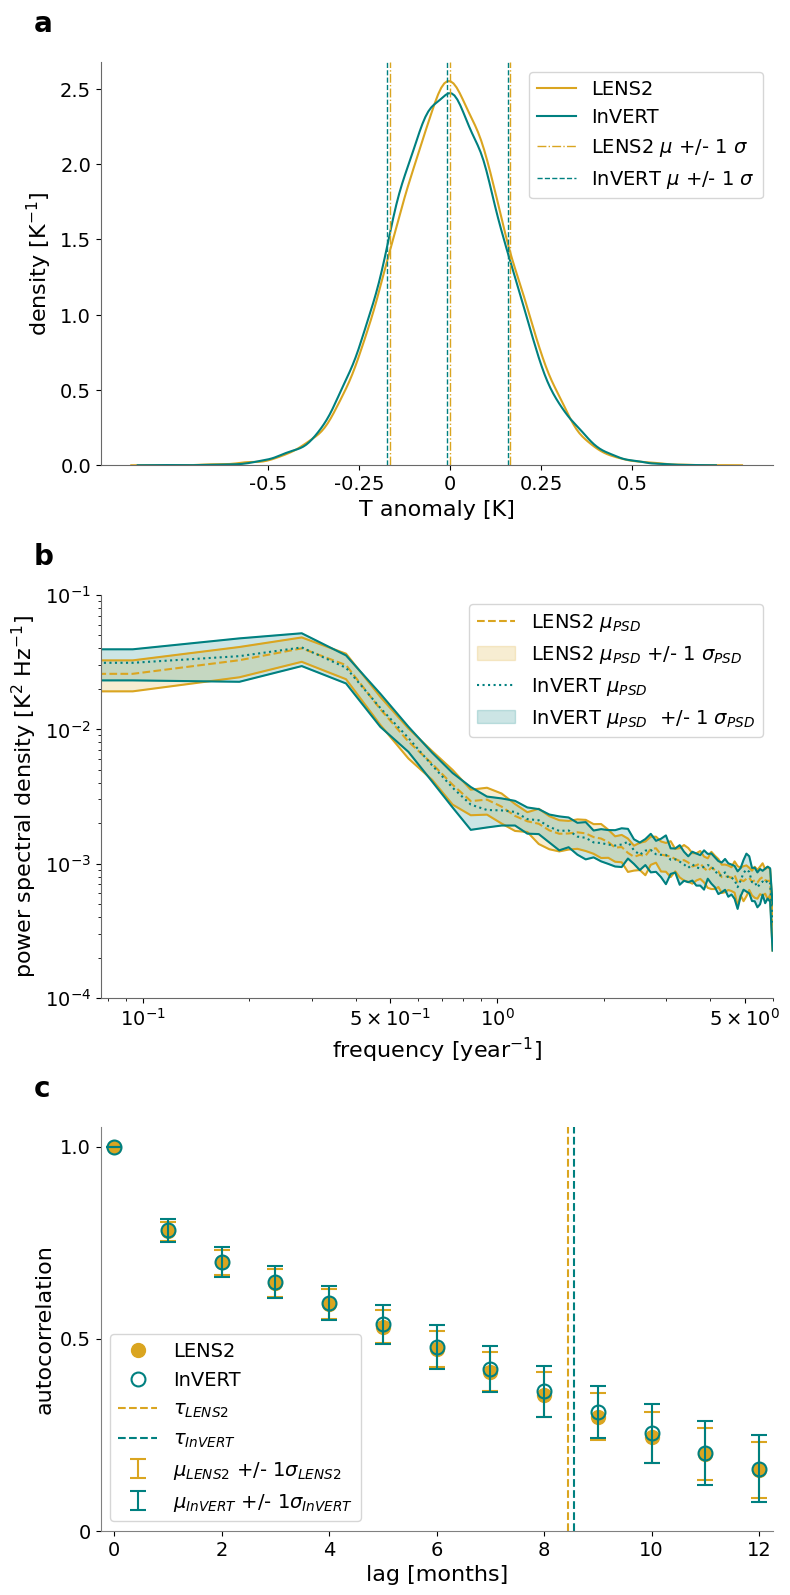

In [18]:
## Figure S1 (GMST pdf, psd, and lag autocorrelations for InVERT trained on SSP370)
titlefontsize=20
plot_GMST_comparisons(T_unstacked, InVERT_T, Tanoms_lens, InVERT_stacked,
                      'LENS2', 'InVERT', color1, color2, savepath, 
                      save_name='Figure_S1_GMST_SSP370')

In [33]:
## Save AR6 regional mean data

# ## Testing data (stacked in time) 
save_region_means(Tanoms_lens, name='LENS2_'+scenario+'_stacked', path=savepath)

## Emulated data (stacked in time)
save_region_means(InVERT_stacked, name='InVERT_'+scenario+'_stacked', path=savepath)

# ## Testing data unstacked 
save_region_means(T_unstacked, name='LENS2_'+scenario, path=savepath)

## Emulated data (not stacked in time)
save_region_means(InVERT_T, name='InVERT_'+scenario, path=savepath)

In [34]:
## Load AR6 regional mean data 

## LENS
T_regional_stacked = xr.open_dataset(savepath + \
            'LENS2_'+scenario+'_stacked_AR6_region_mean_Tanoms.nc')
## INVERT
InVERT_regional_stacked = xr.open_dataset(savepath + \
                               'InVERT_'+scenario+'_stacked_AR6_region_mean_Tanoms.nc')

### By ensemble member

### LENS
T_regional = xr.open_dataset(savepath + 'LENS2_'+scenario+'_AR6_region_mean_Tanoms.nc')

## InVERT
InVERT_regional = xr.open_dataset(savepath + \
                        'InVERT_'+scenario+'_AR6_region_mean_Tanoms.nc')

In [35]:
## Compute ensemble mean and std of PSD of GMST anomaly at each frequency

f, mean_psd, std_psd = calc_psd_stats(T_unstacked.gmean)
invert_f, invert_mean_psd, invert_std_psd = calc_psd_stats(InVERT_T.gmean)

In [36]:
# t test on mean of spectral power at each frequency
print('Compare ensemble means of power at each f'); print(stats.ttest_ind(mean_psd, invert_mean_psd))

# t test on standard deviation of spectral power at each frequency
print('\nCompare ensemble stds of power at each f'); print(stats.ttest_ind(std_psd, invert_std_psd))

# t test on variance of spectral power at each frequency
print('\nCompare ensemble variances of power at each f'); print(stats.ttest_ind(std_psd**2, invert_std_psd**2))

Compare ensemble means of power at each f
TtestResult(statistic=-0.09223805311882226, pvalue=0.9266531101620814, df=128.0)

Compare ensemble stds of power at each f
TtestResult(statistic=-0.4871647302724044, pvalue=0.6269748436563638, df=128.0)

Compare ensemble variances of power at each f
TtestResult(statistic=-0.7577375734202697, pvalue=0.4500008552299345, df=128.0)


In [37]:
## Compare global mean and stds of variances of global mean T anomalies

stds = T_unstacked.gmean.std('time'); stds_invert = InVERT_T.gmean.std('time')

means = T_unstacked.gmean.mean('time'); means_invert = InVERT_T.gmean.mean('time')

variances = T_unstacked.gmean.var('time'); variances_invert = InVERT_T.gmean.var('time')

print('p value: variances of global mean T anomalies', stats.ttest_ind(variances, variances_invert).pvalue)
print('p value: means of GMST anoms', stats.ttest_ind(means, means_invert).pvalue)
print('p value: standard deviations of GMST anoms', stats.ttest_ind(stds, stds_invert).pvalue)

p value: variances of global mean T anomalies 0.2880911032245216
p value: means of GMST anoms 0.5058446151363611
p value: standard deviations of GMST anoms 0.3200141273345709


In [39]:
## Calculate gridcell standard deviations of T anomaly data, by ensemble member

## InVERT
std_invert = InVERT_T.T.std('time') 
## save as netcdf
std_invert.to_netcdf(savepath + 'std_invert.nc'); 

## LENS
std_lens = T_unstacked.anoms.std('time') 
## save as netcdf
std_lens.to_netcdf(savepath + 'std_lens.nc')

In [40]:
## Load gridcell T anomaly standard deviations 
std_invert = xr.open_dataarray(savepath + 'std_invert.nc')
std_lens = xr.open_dataarray(savepath + 'std_lens.nc')

In [41]:
## Compute ensemble mean standard deviations at each gridcell
emean_std_invert = std_invert.mean('ensemble')
emean_std_lens = std_lens.mean('ensemble')

In [42]:
## Compute gridcell PSD of each and save as netcdf
LENS_grid_psd = calc_gridcell_psd(T_unstacked.anoms)
LENS_grid_psd.to_netcdf(savepath + 'LENS_gridcell_psd.nc')

In [43]:
InVERT_grid_psd = calc_gridcell_psd(InVERT_T.T)
InVERT_grid_psd.to_netcdf(savepath + 'InVERT_gridcell_psd.nc')

In [44]:
## Load gridcell PSDs 
LENS_grid_psd = xr.open_dataset(savepath + 'LENS_gridcell_psd.nc')
InVERT_grid_psd = xr.open_dataset(savepath + 'InVERT_gridcell_psd.nc')

In [45]:
## Compute ensemble mean MSE of PSDs at each gridcell
grid_emean_mse = calc_emean_gridcell_MSE(LENS_grid_psd, InVERT_grid_psd)

In [46]:
## Compute e-folding times of T anomalies at every gridcell and save
print('computing gridcell e-folding times (LENS)')
LENS_gridcell_tau = calc_efold_time_dataset(find_var_name(T_unstacked))
LENS_gridcell_tau.to_netcdf(savepath + 'LENS_gridcell_efoldingtimes.nc')

computing gridcell e-folding times (LENS)


In [48]:
print('computing gridcell e-folding times (InVERT)')
InVERT_gridcell_tau = calc_efold_time_dataset(find_var_name(InVERT_T))
InVERT_gridcell_tau.to_netcdf(savepath + 'InVERT_gridcell_efoldingtimes.nc')

computing gridcell e-folding times (InVERT)


In [49]:
## Load saved gridcell autocorrelation e-folding times
efts_invert = xr.open_dataarray(savepath + 'InVERT_gridcell_efoldingtimes.nc')
efts_lens = xr.open_dataarray(savepath + 'LENS_gridcell_efoldingtimes.nc')

In [50]:
## Compile data for Figure S2 map plots

shrink = 0.78 ## fraction for size of colorbar
## ds1: gridcell % difference STD (top left fig 3 subplot)
vmin_pct_std, vmax_pct_std, img, ds1 = plot_gridcell_diff(D1=emean_std_lens, D2=emean_std_invert,
                                            stat='standard deviation', difference='percent',
                                            ax=None, fig=None, shrink = shrink, colorbar=False);
plt.clf();

## ds2: regional percent difference STD (top right fig 3 subplot)
ds2 = plot_regional_diff_map(T_regional, InVERT_regional, ds_gridded=InVERT_T,
                               difference='percent', stat='std', vmin=0, vmax = 30, 
                               ax=None, fig=None, shrink=shrink, colorbar=False); plt.clf();

## ds3: gridcell absolute difference STD (bottom left subplot)
vmin_pct_std, vmax_pct_std, img, ds3 = plot_gridcell_diff(D1=emean_std_lens, D2=emean_std_invert,
                                                stat='standard deviation', difference='absolute',
                                                ax=None, fig=None, shrink = shrink, colorbar=True,
                                                find_vlims=False, vmin=-0.6, vmax=0.6);  plt.clf();
## ds4: gridcell PSD (bottom middle)
ds4 = grid_emean_mse

## ds5: gridcell absolute difference e-folding time (bottom right)
ds5 = efts_lens.mean('ensemble') - efts_invert.mean('ensemble')

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

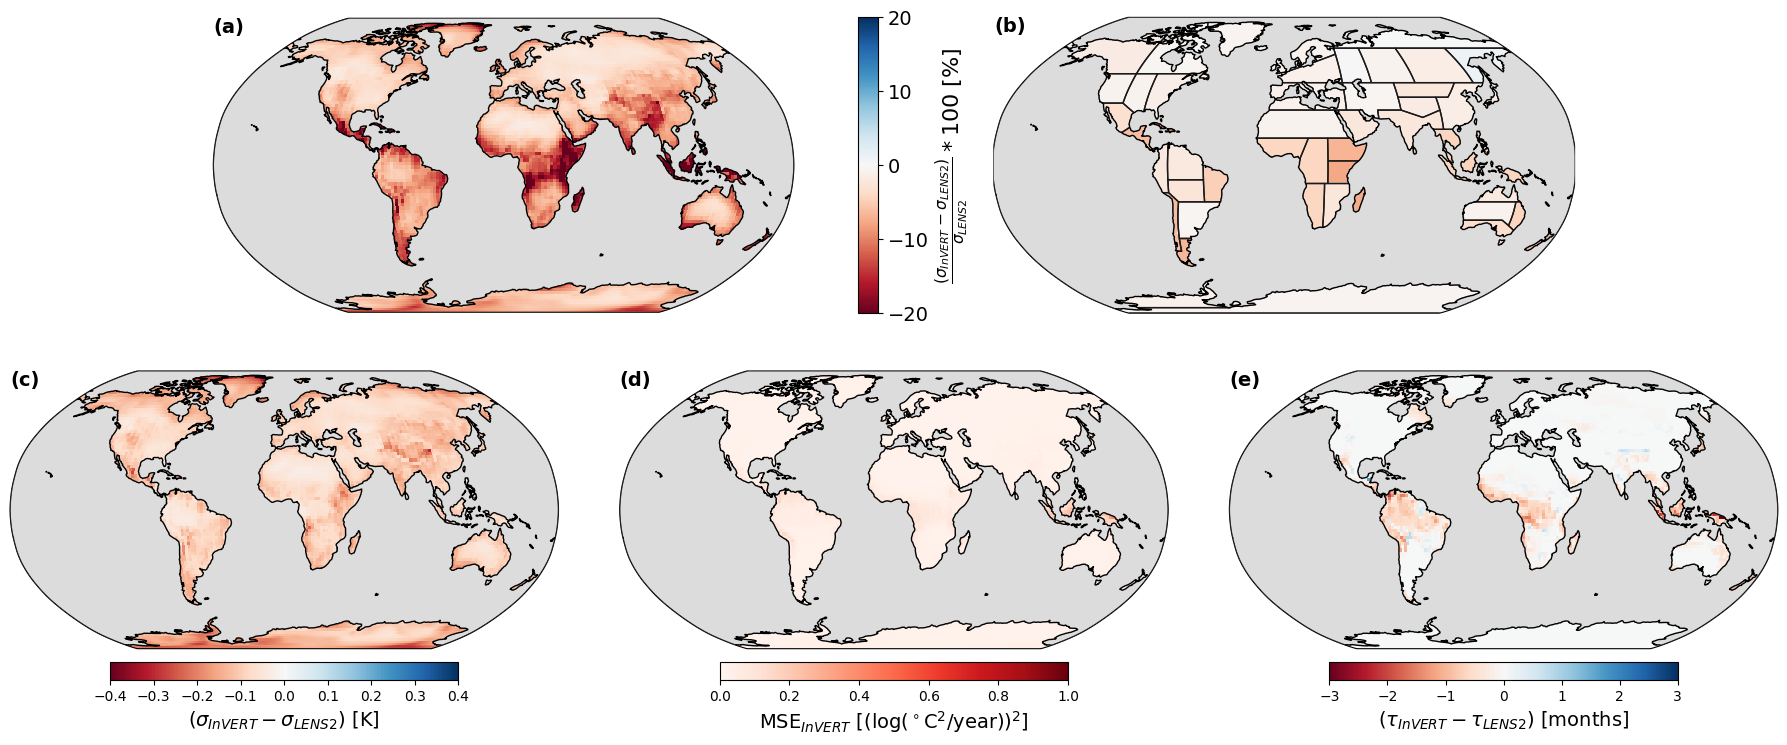

In [51]:
## Plot maps of gridcell and regional differences between InVERT and LENS2 (Figure S2)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8),
                         subplot_kw={'projection': ccrs.Robinson()})
fig.delaxes(axes[0, 2])  # Remove extra subplot in first row 
## First row (2 subplots)
ax = axes[0,0]
im1 = ax.pcolormesh(ds1['lon'], ds1['lat'], ds1.values, transform=ccrs.PlateCarree(), 
                    cmap='RdBu', vmin=-20, vmax=20) 
ax = axes[0, 1]
im2 = axes[0, 1].pcolormesh(ds2['lon'], ds2['lat'], ds2.values, transform=ccrs.PlateCarree(),
                            cmap='RdBu', vmin=-20, vmax=20)
## Get AR6 land regions
regions = regionmask.defined_regions.ar6.land
## Plot AR6 region boundaries 
regions.plot(ax=ax, add_ocean=True, ocean_kws={'facecolor': 'lightgray'}, label='number',
             text_kws={'visible':False}, line_kws={'lw':1}) # linewidth of region boundaries
ax = axes[1,0]
im3 = ax.pcolormesh(ds3['lon'], ds3['lat'], ds3.values, transform=ccrs.PlateCarree(),
                    cmap='RdBu', vmin=-0.4, vmax=0.4)
ax = axes[1,1]
im4 = ax.pcolormesh(ds4['lon'], ds4['lat'], ds4.values, transform=ccrs.PlateCarree(),
                    cmap='Reds', vmin=0, vmax=1)
ax = axes[1,2]
im5 = ax.pcolormesh(ds5['lon'], ds5['lat'], ds5.values, transform=ccrs.PlateCarree(), 
                    cmap='RdBu', vmin=-3, vmax=3)
for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[1,2]]:
    ax.stock_img() # Add stock image to mask ocean
    ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='black', facecolor='gainsboro')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95,
                    wspace=0.05, hspace=0.1) # Reduce  spacing between subplots                   
## Increase horizontal space between top two subplots center them in the top row
extra_space = 0.1  # Adjust this value to control the extra space
## Get the original positions of both top subplots
pos1 = axes[0, 0].get_position(); pos2 = axes[0, 1].get_position()
## Calculate total width of top two subplots plus extra space
total_width = pos1.width + pos2.width + extra_space
## Calculate starting position to center top 2 subplots
start_position = (1 - total_width) / 2  # 1 represents the total figure width
## Shift left subplot to starting position
axes[0, 0].set_position([start_position, pos1.y0, pos1.width, pos1.height])
## Shift right subplot to the right of left subplot with extra space
axes[0, 1].set_position([start_position + pos1.width + extra_space, pos2.y0, pos2.width, pos2.height])
## Recompute colorbar center position 
left_edge = axes[0, 0].get_position().x1; right_edge = axes[0, 1].get_position().x0
center_position = (left_edge + right_edge) / 2
cbar_ax = fig.add_axes([center_position - 0.018, 
                        axes[0, 1].get_position().y0, 0.01,
                        axes[0, 1].get_position().height])
fig.colorbar(im1, cax=cbar_ax, orientation='vertical') 
## Add subplot labels
axes[0, 0].text(0.00, 1.00, '(a)', transform=axes[0, 0].transAxes, fontsize=14, fontweight='bold', va='top')
axes[0, 1].text(0.00, 1.00, '(b)', transform=axes[0, 1].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 0].text(0.00, 1.00, '(c)', transform=axes[1, 0].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 1].text(0.00, 1.00, '(d)', transform=axes[1, 1].transAxes, fontsize=14, fontweight='bold', va='top')
axes[1, 2].text(0.00, 1.00, '(e)', transform=axes[1, 2].transAxes, fontsize=14, fontweight='bold', va='top')
## Adjust tick parameters for vertical color bar:
cb_vert = fig.colorbar(im1, cax=cbar_ax, orientation='vertical')
cb_vert.ax.tick_params(labelsize=14)
## Adjust font size of labels for bottom row colorbars 
for ax in axes[1,:]: # get axes for colorbars in the bottom row
    if ax == axes[1,0]:
        cb = plt.colorbar(im3, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04)
        cb.set_label(label=r'($\sigma_{InVERT}-\sigma_{LENS2}$) [K]', size=14)  
    if ax == axes[1,1]:
        cb = plt.colorbar(im4, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04)
        cb.set_label(label='MSE$_{InVERT}$ [(log($^\circ$C$^{2}$/year))$^{2}$]', size=14)          
    if ax == axes[1,2]:
        cb = plt.colorbar(im5, ax=ax, orientation='horizontal', shrink=0.6, pad=0.04,)
        cb.set_label(label=r'$(\tau_{InVERT} - \tau_{LENS2})$ [months]', size=14)  
## Adjust label for the vertical colorbar:
cb_vert.set_label(label=r'$\frac{(\sigma_{InVERT}-\sigma_{LENS2})}{\sigma_{LENS2}}*100$ [%]', 
                  size=16)
plt.show()
fig.savefig(savepath + 'Figure_S2_regional_subplots_SSP370.pdf'); 
fig.savefig(savepath + 'Figure_S2_regional_subplots_SSP370.png'); 

In [19]:
## Figure S6 - Ensemble mean monthly standard deviations of temperature anomalies 
## (as in main text Figure 4) for InVERT trained on LENS2 SSP370)

print('Plotting local monthly standard deviations')

## Convert longitude for ensemble-separated datasets
InVERT_T_converted_lon = convert_lon(InVERT_T, 'lon')
LENS_converted_lon = convert_lon(T_unstacked, 'lon')

Plotting local monthly standard deviations


In [20]:
## Calculate ensemble mean standard deviations of T anomalies by month
LENS_emean_monthly_stds = LENS_converted_lon.anoms.groupby('month').std('time').mean('ensemble')
InVERT_emean_monthly_stds = InVERT_T_converted_lon.T.groupby('month').std('time').mean('ensemble')

In [21]:
## Calculate ensemble standard deviation of T anomaly standard deviations by month
LENS_estd_monthly_stds = LENS_converted_lon.anoms.groupby('month').std('time').std('ensemble')
InVERT_estd_monthly_stds = InVERT_T_converted_lon.T.groupby('month').std('time').std('ensemble')

### Figure S6


New York City, United States: 40.1029793042494, -73.125
Beijing, China: 40.1029793042494, 116.25
New Delhi, India: 28.91149236871774, 76.875
Cairo, Egypt: 30.77674406172325, 31.875


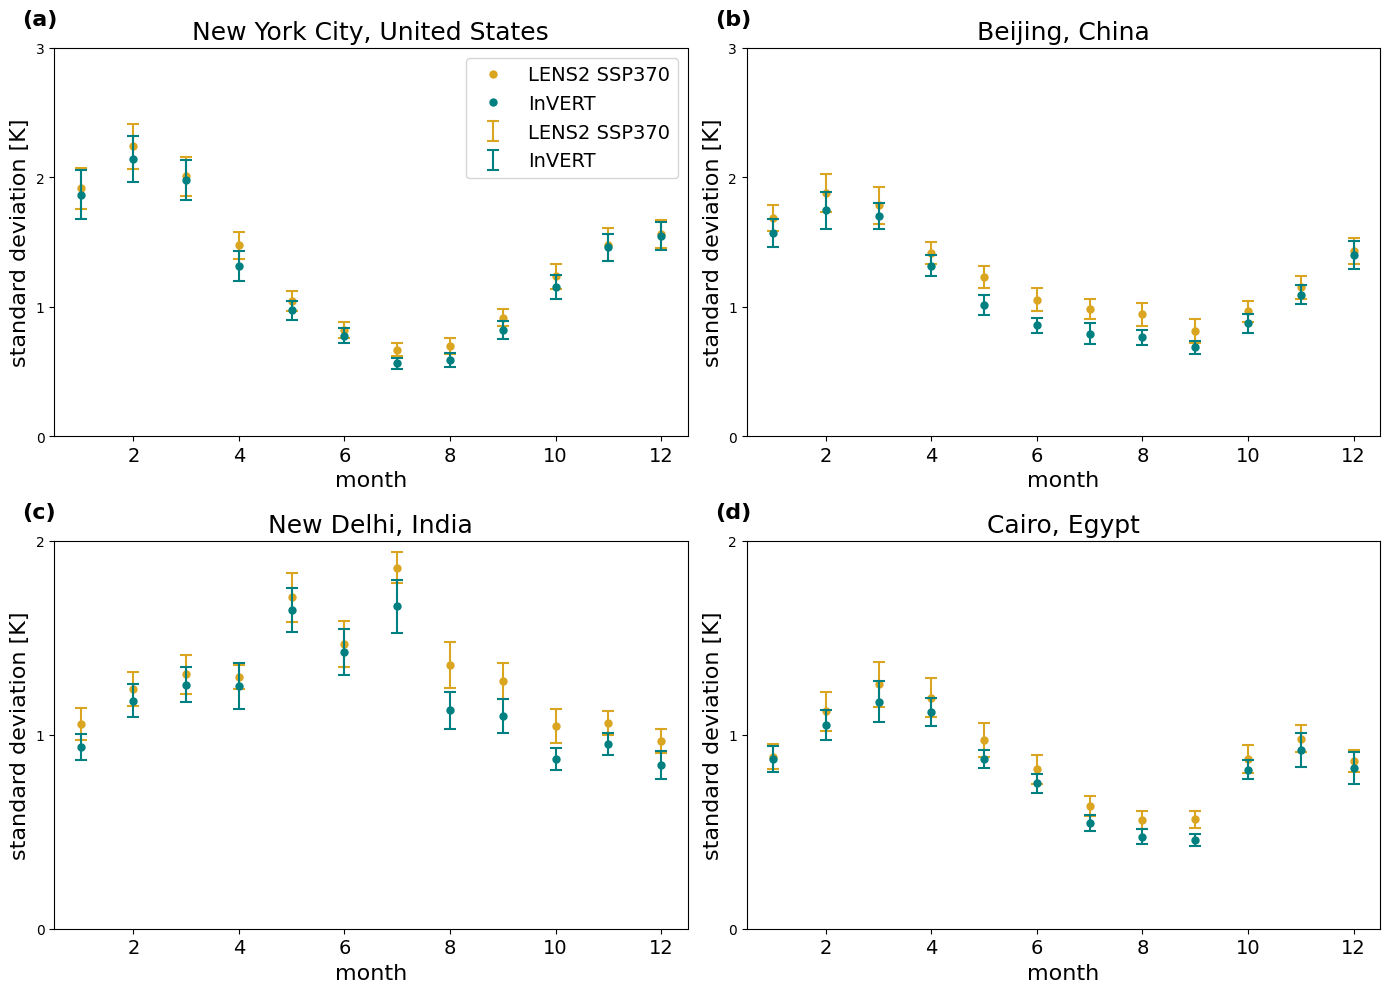

In [23]:
locations_lat_lon = [(40.7, -74, 'New York City, United States'),
                     (39.9, 116.4, 'Beijing, China'),
                     (28.7, 77.2, 'New Delhi, India'),
                     (30.05, 31.23, 'Cairo, Egypt' )]

plot_local_monthly_T_stds(LENS_emean_monthly_stds, InVERT_emean_monthly_stds,
                          LENS_estd_monthly_stds, InVERT_estd_monthly_stds,
                          locations_lat_lon, savepath, ylim=[3,3,2,2], 
                          save_name='Figure_S6_monthly_mean_stds_SSP370',
                          name1='LENS2 SSP370', name2='InVERT')